## Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC , SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
# !pip install xgboost
from xgboost import XGBClassifier

## Data preparation

In [2]:
clean_df = pd.read_csv('../data/processed/video_data_processed.csv').copy()

In [3]:
clean_df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,hour,day,day_of_week,month,year
45300,a9HTZJMelv0,Jovian,Image Classification with Logistic Regression ...,“Deep Learning with PyTorch: Image Classificat...,machine learning|deep learning|pytorch|webinar...,2019-11-30 07:37:51+00:00,3235,67,5,5637,hd,False,7,30,5,11,2019
24016,4jrOsD1Wd2g,The Data Incubator,Data Science Bootcamp Cost & Financing 101,Source:\r\nhttps://www.podbean.com/eau/pb-8f59...,podbean,2023-03-17 15:53:25+00:00,23,0,0,1701,hd,False,15,17,4,3,2023
57408,cJ36jG_jaew,Data36 - Online Data Science Courses,"SQL functions, GROUP BY, ORDER BY, DISTINCT --...",*****\r\nIMPORTANT!!! I moved the datafile fro...,online data analysis|data science|data science...,2020-12-03 14:42:07+00:00,2635,81,16,1897,hd,False,14,3,3,12,2020
30779,x_bw_IHjCWU,AssemblyAI,How ChatGPT actually works,"Since its release, the public has been playing...",(notag),2023-01-23 15:00:38+00:00,31316,681,25,386,hd,False,15,23,0,1,2023
11224,Md6InwA00vw,Analytics Vidhya,Advanced Resume Shortlisting using NLP | DataH...,"In the present day, the official career page m...",(notag),2023-02-14 04:08:25+00:00,4765,101,10,3427,hd,False,4,14,1,2,2023


# Problem Statement
...

## Feature engineering

### Select features (independent variables) and the target variable (dependent variable)
- Here, we will construct a classification model for predicting the video engagement. Our target variable will be `Trending` and we will examine our columns to select suitable features.
- Firstly, we have to create the new feature `Trending` based on `viewCount`.
- <font color=red>Noted:</font> We assume that `low`: 0, `medium`: 1, `high`: 2

Visualize the distribution of engagement values

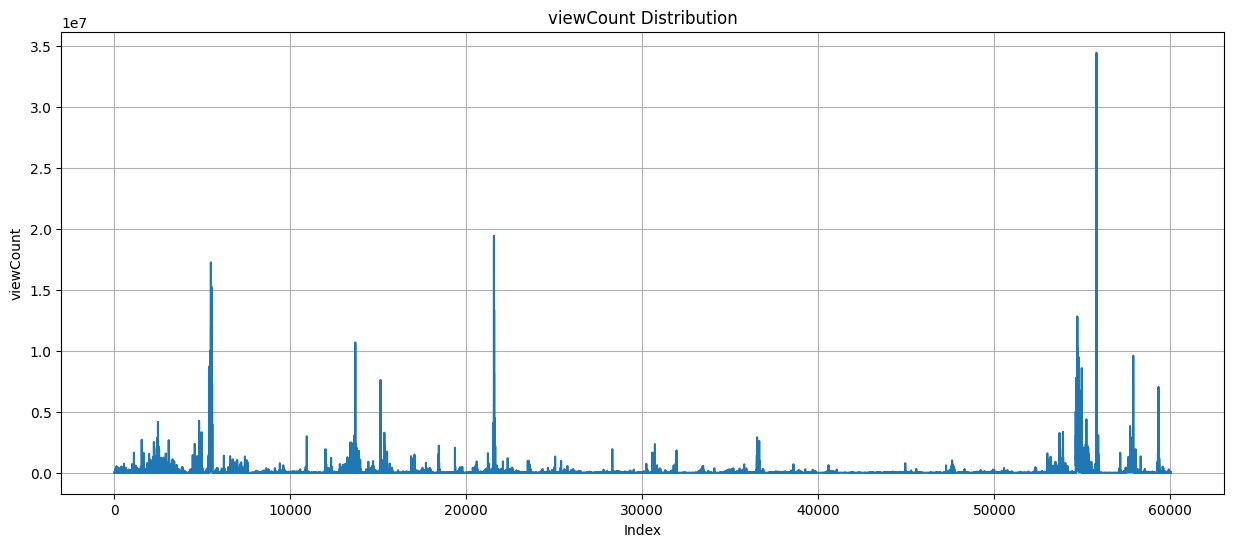

In [15]:
plt.figure(figsize=(15, 6))
plt.plot(clean_df['viewCount'])
plt.title('viewCount Distribution')
plt.xlabel('Index')
plt.ylabel('viewCount')
plt.grid(True)
plt.show()

Create a `Trending` column based on our criteria for the `viewCount` values, where labels 'low', 'medium', 'high' are assigned based on the mean value.

In [17]:
# calculate mean of viewCount
mean_engagement = clean_df['viewCount'].mean()

# assign labels based on the engagement
clean_df['Trending'] = pd.cut(clean_df['viewCount'], 
                               bins=[float('-inf'), mean_engagement, mean_engagement *10, float('inf')], 
                               labels=False)

## Baseline model comparison

In [18]:
X = clean_df[['likeCount', 'commentCount', 'hour', 'day', 'month', 'year']]
y = clean_df['Trending']

In [19]:
# dividing data into train, valid and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y ,test_size=0.3, random_state= 2023,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp ,test_size=0.3, random_state= 2023,stratify=y_tmp)

In [20]:
seed = 2023
models = [
    LinearSVC(random_state=seed, dual=False, max_iter=1000),
    SVC(random_state=seed),
    RandomForestClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed)
]

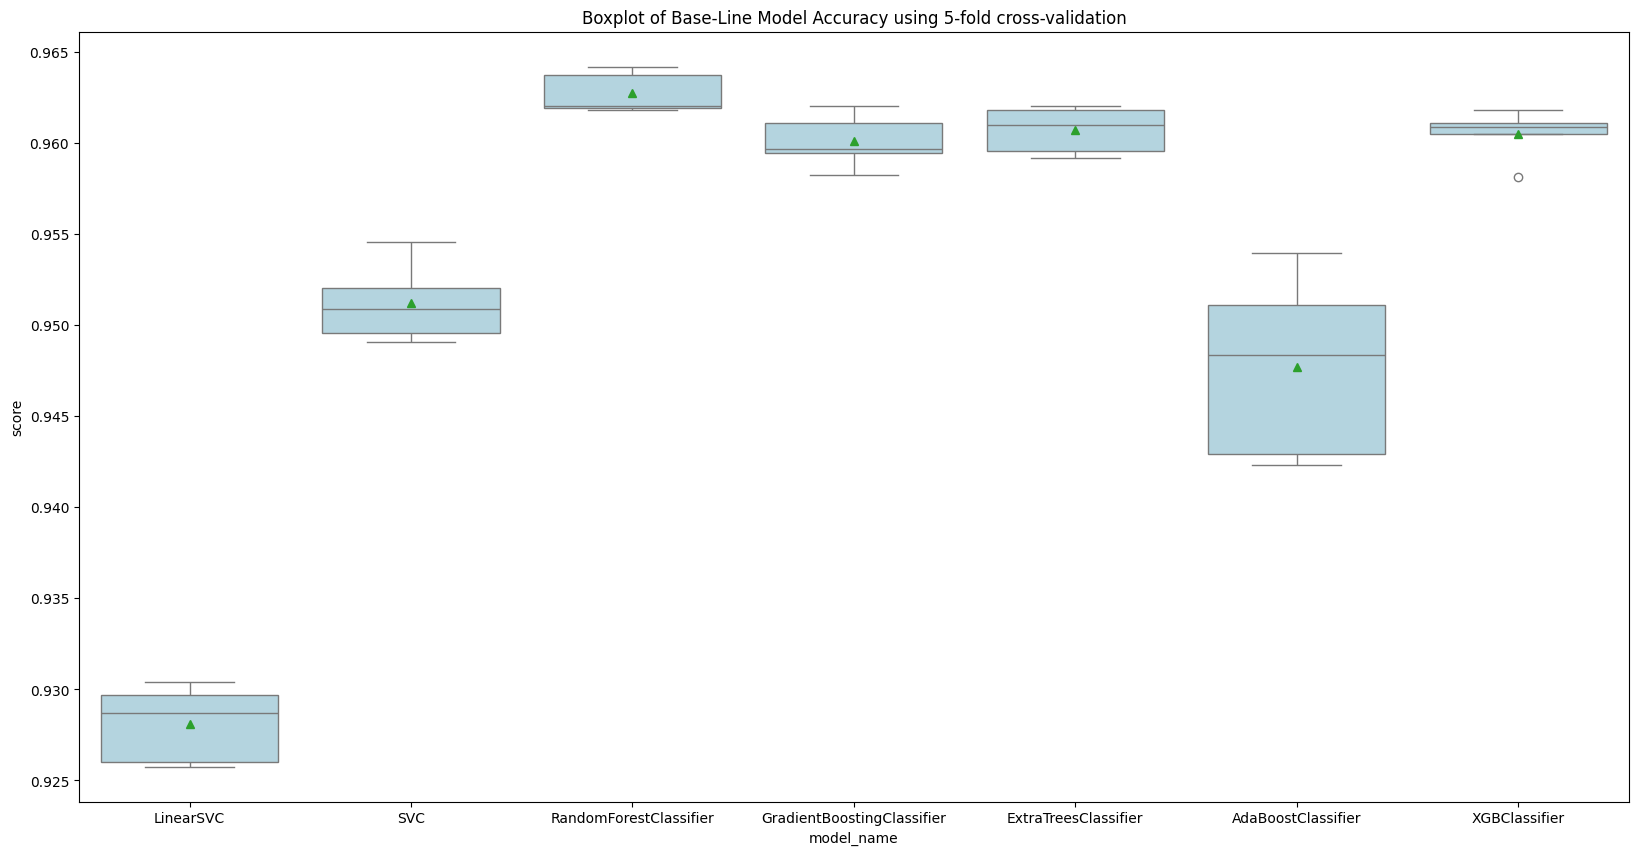

,Mean,Standard Deviation
model_name,,
RandomForestClassifier,0.962734,0.001124
ExtraTreesClassifier,0.960711,0.001296
XGBClassifier,0.960473,0.001402
GradientBoostingClassifier,0.960092,0.001491
SVC,0.951216,0.002198
AdaBoostClassifier,0.947718,0.005087
LinearSVC,0.928109,0.002127


In [21]:
def generate_baseline_result(models, X, y, metrics, cv, plot_result=False):
    # define k-fold
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_val_score(model, X, y, scoring=metrics, cv=kfold)
        for fold_idx, score in enumerate(scores):
            entries.append((model_name, fold_idx, score))

    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'score'])
    
    mean = cv_df.groupby('model_name')['score'].mean()
    std = cv_df.groupby('model_name')['score'].std()
    
    baseline_results = pd.concat([mean,std],axis =1, ignore_index=True)
    baseline_results.columns =['Mean','Standard Deviation']
    baseline_results.sort_values(by=['Mean'], ascending = False, inplace = True)
    
    if plot_result:
        plt.figure(figsize=(20, 10))
        sns.boxplot(x ='model_name',y = 'score', data = cv_df, color ='lightblue',showmeans=True)
        plt.title('Boxplot of Base-Line Model Accuracy using 5-fold cross-validation')
        plt.show()
    
    return baseline_results

generate_baseline_result(models, X_train, y_train, metrics='accuracy',cv=5,plot_result =True )

## Fine - tune

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(RandomForestClassifier(random_state=2023),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_val, y_val)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = RandomForestClassifier(random_state=2023, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
print(f"Best Model Accuracy: {accuracy_score(y_test, y_pred_best)}")

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Model Accuracy: 0.968985484254779


## Re-train

In [12]:
final_model_train_valid = RandomForestClassifier(random_state=2023, **best_params)

X_train_valid = pd.concat([X_train, X_val], axis=0)
y_train_valid = pd.concat([y_train, y_val], axis=0)
final_model_train_valid.fit(X_train_valid, y_train_valid)

RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=2023)

## Test on test set

In [13]:
y_pred_final_train_valid = final_model_train_valid.predict(X_test)
accuracy_final_train_valid = accuracy_score(y_test, y_pred_final_train_valid)

## Evaluation

In [14]:
print(f"Accuracy of the Final Model on Test Set: {accuracy_final_train_valid}")

Accuracy of the Final Model on Test Set: 0.9685888791940985
